## Stokes Flow in Periodic Channel with Robin boundary.

In [1]:
import sys
sys.path.append('/home/emastr/phd/')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "none"#"last_expr_or_assign"

import numpy as np
import matplotlib.pyplot as plt
from util.logger import EventTracker
from util.basis_scaled import *
from util.plot_tools import *
from boundary_solvers.gauss_grid_2d import StokesDirichletProblem
from scipy.io import loadmat
import matplotlib.pyplot as plt
from util.interp import PiecewiseInterp2D
from hmm.stokes import *
from itertools import product

pretty_pyplot_layout()

## Multiscale Problem

We define a multiscale problem as follows. The PDE is a non-slip zero forcing Stokes flow Problem

\begin{equation}
\Delta u  - \nabla p = 0, \qquad \qquad \nabla \cdot u = 0   \qquad \text{inside}\quad \Omega
\end{equation}

with the boundary conditions

\begin{equation}
u = g,\qquad \text{on}\quad\partial\Omega
\end{equation}

the boundary is a two-dimensional pipe with corners at (0,-1) and (1,1), and a micro scale boundary:

## Coupling to Micro Domain

To couple the macro domain to the microscopic domain, we make use of the HMM framework.
We construct a set of evenly spaced micro problems based on the Stokes data. The macro problem is constructed with a pre-specified resolution in the x- and y-directions.

In [5]:
from dataclasses import dataclass
from multiprocessing import Pool

@dataclass
class HyperParams:
    nMic: int
    n_refine: int
    xDim: int
    yDim: int
    width: float
    height: float
    tol: float
    max_iter: int
    alpha_error: float = 0.0
        
    
    
class Setup():
    def __init__(self, data: StokesData, param: HyperParams):
        """Create a new HMM setup with the given parameters."""
        self.params = param
        self.data = data
        
        # Macro problem
        errors = 
        macro = StokesMacProb(data, lambda x,a: fft_interp(x, [ai + param.height*param.alpha_error*np.random.rand() for ai in a], dom=data.dom[0]))
        macro_solver = MacroSolver(param.xDim, param.yDim, tol=param.tol)
        
        # Micro problems
        self.xPos = np.linspace(data.dom[0][0], data.dom[0][1], param.nMic+1)[1:] - param.width/2 - (data.dom[0][1]-data.dom[0][0]) / param.nMic/1
        micros = [StokesMicProb(data, x, param.width, param.height, 0.0, 8, param.xDim, param.yDim, n_refine=param.n_refine) for x in self.xPos]
        micro_solvers = [MicroSolver(m, tol=param.tol) for m in micros]
        
        # Convergence checker
        conv_checker = ConvergenceChecker(macro, micros, tol=param.tol)
        
        # HMM problem
        self.hmm_problem = StokesHMMProblem(macro, micros, data, convergence_checker=conv_checker)
        self.hmm_solver = IterativeHMMSolver(macro_solver, micro_solvers)
        
        
    def solve(self, **kwargs):
        macro_guess = self.hmm_solver.macro_solver.solve(self.hmm_problem.macro)
        (macro_sol, micro_sols) = self.hmm_solver.solve(self.hmm_problem, macro_guess=macro_guess, verbose=True, maxiter=self.params.max_iter, tol=self.params.tol)
        return micro_sols, macro_sol, macro_guess
    
    
    def save_sol(self, macro_sol, filename):
        data = self.params.__dict__
        data['sol_u'] = macro_sol.u.eval_grid()
        data['sol_v'] = macro_sol.v.eval_grid()
        np.save(filename, data)
        
        
    def load_sol(filename):
        data = np.load(filename, allow_pickle=True).flatten()[0]
        u = data.pop('sol_u')
        v = data.pop('sol_v')
        par = HyperParams(**data)
        return par, u, v

## Solving using HMM iterations

To solve the problem, we make use of a sequence of micro solvers, as well as a micro solver.

In [6]:
# range of data to use : 25 - 59
    
#w_list = [1, 2, 3, 4, 5, 6, 7, 8]
#n_list = [3, 5, 7, 9, 11, 13, 15, 17]
i_list = list(range(25, 60, 5))

w_list = [4]
n_list = [5]
a_list = [10, 5, 3, 2, 1]#, 3, 2, 1, 0]

args = [(i, n, w, a) for i, n, w, a in product(i_list, n_list, w_list, a_list)]
        

def solve_save(i, n, w, log_a):
    data, info = StokesData.load_from_matlab(f"/home/emastr/phd/data/reference/run_{i}.mat")
    data_big_domain = data
    dom = data.dom
    eps = info["eps"]
    print(f"i={i}, (n={n}, w={w}, a={10**(-log_a)})")
    params = HyperParams(nMic=n, n_refine=1, xDim=21, yDim=21, width=w*eps, height=w*eps, tol=1e-8, max_iter=30, alpha_error=10**(-log_a))
    setup = Setup(data, params)
    micro_sols, macro_sol, macro_guess = setup.solve()
    setup.save_sol(macro_sol, f"/home/emastr/phd/data/hmm_sols/sol_{i}_{n}_{w}_{log_a}.npy")
    

In [7]:
Pool(16).starmap(solve_save, args)

i=25, (n=5, w=4, a=1e-10)
i=30, (n=5, w=4, a=0.1)
i=35, (n=5, w=4, a=1e-10)i=35, (n=5, w=4, a=1e-05)

i=35, (n=5, w=4, a=0.001)i=35, (n=5, w=4, a=0.01)i=30, (n=5, w=4, a=1e-05)

i=25, (n=5, w=4, a=0.01)

i=25, (n=5, w=4, a=1e-05)i=30, (n=5, w=4, a=0.01)i=30, (n=5, w=4, a=0.001)


i=25, (n=5, w=4, a=0.1)
i=25, (n=5, w=4, a=0.001)
i=30, (n=5, w=4, a=1e-10)
i=35, (n=5, w=4, a=0.1)
i=40, (n=5, w=4, a=1e-10)
Convergence (not necessarily to solution) at step 9/30Step 3/30Step 5/30Step 5/30Step 6/30Step 6/30Step 7/30Step 7/30Step 8/30Step 8/30
i=40, (n=5, w=4, a=1e-05)
Convergence (not necessarily to solution) at step 10/30
i=40, (n=5, w=4, a=0.001)
Convergence (not necessarily to solution) at step 11/30
i=40, (n=5, w=4, a=0.01)
Convergence (not necessarily to solution) at step 11/30
i=40, (n=5, w=4, a=0.1)Step 0/30
i=45, (n=5, w=4, a=1e-10)/30Step 16/30Step 16/30Step 6/30Step 5/30Step 23/30Step 24/30
i=45, (n=5, w=4, a=1e-05)
i=45, (n=5, w=4, a=0.001)
i=45, (n=5, w=4, a=0.01)
i=45, (n=5, w=4

/home/emastr/phd/util/basis_scaled.py:416: RuntimeWarning: invalid value encountered in multiply
  return ifft(ifftshift(coef)) * len(coef)
/home/emastr/phd/util/basis_scaled.py:345: RuntimeWarning: invalid value encountered in multiply
  f *= other.eval_grid()
/home/emastr/phd/util/basis_scaled.py:424: RuntimeWarning: overflow encountered in multiply
  coef = (freq ** deg) * coef
/home/emastr/phd/util/basis_scaled.py:482: RuntimeWarning: invalid value encountered in multiply
  prod = BasisProduct(self.coef * other, self.xDim, self.yDim, self.xBasis, self.yBasis)
/home/emastr/phd/util/basis_scaled.py:734: RuntimeWarning: invalid value encountered in multiply
  return ScaleShiftedBasisProduct(rescale * self.basis.diff(xDeg, yDeg), self.scale, self.shift)
/home/emastr/phd/util/basis_scaled.py:482: RuntimeWarning: overflow encountered in multiply
  prod = BasisProduct(self.coef * other, self.xDim, self.yDim, self.xBasis, self.yBasis)
/home/emastr/phd/util/basis_scaled.py:734: RuntimeWarni

/home/emastr/phd/hmm/stokes.py:327: RuntimeWarning: invalid value encountered in multiply
  return np.real(dz_) * dxU(z_) + np.imag(dz_) * dyU(z_)
/home/emastr/phd/hmm/stokes.py:296: RuntimeWarning: invalid value encountered in multiply
  return lambda z: fx(np.real(z), np.imag(z)) + 1j * fy(np.real(z), np.imag(z))
/home/emastr/phd/hmm/stokes.py:338: RuntimeWarning: invalid value encountered in multiply
  return ddx * dxU(z_) + ddy * dyU(z_) + (dx**2) * dxdxU(z_) + (2*dx*dy)*dxdyU(z_) + (dy**2)*dydyU(z_)


/home/emastr/phd/boundary_solvers/geometry.py:1016: RuntimeWarning: invalid value encountered in multiply
  return self.inner(1j * v, f)
/home/emastr/anaconda3/envs/pimlenv/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:206: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


In [51]:
#I = 25
#w_list = [1,]# 3, 5]#, 6, 7]
#n_list = [3,]# 11, 17]
#i_list = [25, 35, 45]

#args = [(i, n, w) for i, n, w in product(i_list, n_list, w_list)]
errs = {'max':[], 'L1':[], 'L2':[]}
idx2eps = {}

for i, n, w, a in list(args):
    par, u, v = Setup.load_sol(f"/home/emastr/phd/data/hmm_sols/sol_{i}_{n}_{w}_{a}.npy")
    data, info = StokesData.load_from_matlab(f"/home/emastr/phd/data/reference/run_{i}.mat")
    
    # U HMM solution
    coef = BasisProduct._interpolate(u, FourBasis, ChebBasis)
    u_basis = BasisProduct(coef, *coef.shape, FourBasis, ChebBasis)
    scale, shift = ScaleShiftedBasisProduct._domain_to_scale_shift(u_basis.domain(), data.dom)
    u_basis = ScaleShiftedBasisProduct(u_basis, scale, shift)
        
    # U true solution
    bbox = info["bbox"]
    Uc = info['Uc']
    eps = float(info['eps'])
    nper= int(info['freq_g'])
    idx2eps[i] = (eps, nper)
    x = np.linspace(bbox[0][0],bbox[0][1],Uc.shape[0])
    y = np.linspace(bbox[1][0],bbox[1][1],Uc.shape[1])
    u_sol = PiecewiseInterp2D(x, y, Uc)
    
    print(f"{i}, {eps}, {nper}, {n}, {w}", end="\r")
    
    # Evaluate on strip close to the wall
    y_val_1 = 2*eps*np.log(1/eps)
    y_val_0 = 0.5*eps*np.log(1/eps)
    area = 1#(y_val_1 - y_val_0)*(data.dom[0][1] - data.dom[0][0])
    nx = 100
    ny = 20
    Xval, Yval = np.meshgrid(np.linspace(*data.dom[0], nx), np.linspace(y_val_0, y_val_1, ny))
    err = np.abs(u_sol(Xval, Yval) - u_basis(Xval.flatten(), Yval.flatten()).reshape(ny, nx))
    errs['max'].append(np.max(err))
    errs['L1'].append(np.mean(err)*area)
    errs['L2'].append(np.sqrt(np.mean(err**2))*area)
    
    

    # Plot result
    #u_basis = u_basis.change_dim(201,201)
    #X, Y = u_basis.grid()
    #U_b = u_basis.eval_grid()
    #U_s = u_sol(X, Y)
    
    #plt.figure()
    #plt.title(f"Run {i}, eps={eps:.3f}, nMic={n}, width={w}*eps")
    #plt.grid(False)
    #data.plot(plt.gca(), npts=2000)
    #plt.pcolormesh(X, Y, np.log10(np.abs(U_b - U_s)), vmin=-7, vmax=-1)
    #plt.plot(np.linspace(*data.dom[0], 100), np.ones(100)*y_val_1, 'red')
    #plt.plot(np.linspace(*data.dom[0], 100), np.ones(100)*y_val_0, 'red')
    
    
    #plt.colorbar()
    #plt.xlim(data.dom[0])
    #plt.ylim(data.dom[1])

#import pandas as pd
#table = pd.DataFrame(errs, index=pd.MultiIndex.from_tuples(args, names=['i', 'n', 'w']))
np.save("/home/emastr/phd/data/hmm_sols/sol_table.npy", [args, errs, idx2eps])

/home/emastr/anaconda3/envs/pimlenv/lib/python3.8/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


25
[ 1.5  2.   3.   5.  10. ] [[0.01560526]
 [0.01517428]
 [0.01497261]
 [0.01494963]
 [0.01494939]]
30
[ 1.5  2.   3.   5.  10. ] [[0.05277134]
 [0.05233592]
 [0.05213177]
 [0.05210851]
 [0.05210827]]
35
[ 1.5  2.   3.   5.  10. ] [[0.00829747]
 [0.00788699]
 [0.00804165]
 [0.00806201]
 [0.00806222]]
40
[ 1.5  2.   3.   5.  10. ] [[0.04716006]
 [0.04569074]
 [0.04507671]
 [0.04505017]
 [0.04505046]]
45
[ 1.5  2.   3.   5.  10. ] [[0.00658588]
 [0.00471539]
 [0.00436495]
 [0.00432622]
 [0.00432583]]
50
[ 1.5  2.   3.   5.  10. ] [[0.03883423]
 [0.03795348]
 [0.03800584]
 [0.03805212]
 [0.03805258]]
55
[ 1.5  2.   3.   5.  10. ] [[0.07791895]
 [0.07596525]
 [0.07539222]
 [0.07529459]
 [0.07529522]]


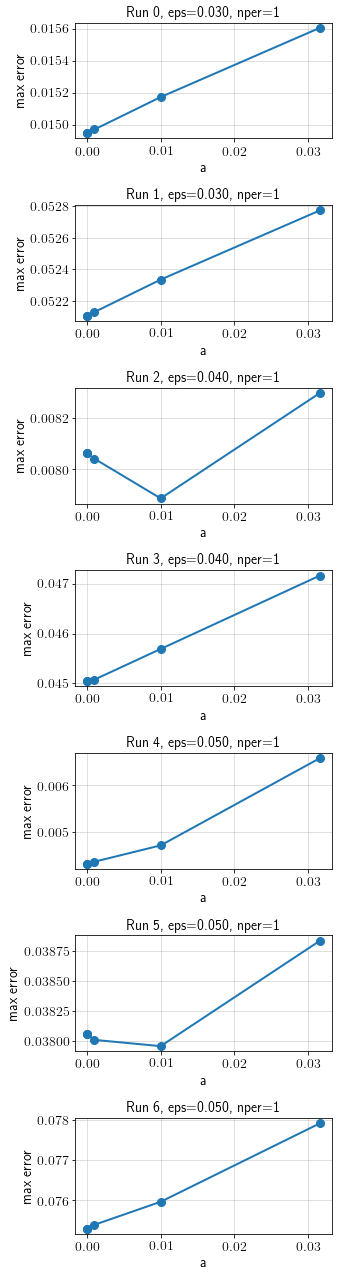

In [53]:
import pandas as pd
i_range = list(range(25, 60, 5))# list(range(25, 60, 1))
#n = int(np.ceil(len(i_range)**0.5))
n_rows = 8
n_cols = 5

plt.figure(figsize=(20,20))
for it, i in enumerate(i_range):
    
    grid_search = np.load("/home/emastr/phd/data/hmm_sols/sol_table.npy", allow_pickle=True)
    vals = list(zip(*list(grid_search[1].values())))
    idx2eps = grid_search[2]

    table = pd.DataFrame(vals, index=pd.MultiIndex.from_tuples(grid_search[0], names=['i', 'n', 'w', 'a']), columns=list(grid_search[1].keys()))
    table_max = table['max']
    print(i)
    table_max = table_max.unstack(level=1).loc[(i, slice(None))]
    #print(table_max.index)

    row = it%n_rows
    col = int(np.floor(it/n_rows))
    
    plt.subplot(n_rows, n_cols, row*n_cols + col + 1, title=f"Run {it}, eps={idx2eps[i][0]:.3f}, nper={idx2eps[i][1]}")
    
    x = np.array([v[1] for v in table_max.index.values]).astype(float)
    y = table_max.values
    print(x, y)
    plt.plot(10**(-x), y, 'o-')
    plt.xlabel("a")
    plt.ylabel("max error")
    
    #plt.pcolormesh(table_max.columns, table_max.index, np.log10(table_max.values))
    #plt.colorbar()
    #plt.ylabel("width/eps")
    #plt.xlabel("nMic")
    #plt.xticks(table_max.columns)
    #plt.yticks(table_max.index)
    
    plt.title(f"Run {it}, eps={idx2eps[i][0]:.3f}, nper={idx2eps[i][1]}")
    
    #print(table.loc((25, 0.5, 3)))
    #print(table)
    #help(table)
    #print(table['max'])


In [5]:
I = 25
w_list = [4,]# 3, 5]#, 6, 7]
n_list = [15,]# 11, 17]
i_list = [35]

args3 = [(i, n, w) for i, n, w in product(i_list, n_list, w_list)]

for i, n, w in list(args3):
    par, u, v = Setup.load_sol(f"/home/emastr/phd/data/hmm_sols/sol_{i}_{n}_{w}.npy")
    data, info = StokesData.load_from_matlab(f"/home/emastr/phd/data/reference_3/run_{i}.mat")
    
    # U HMM solution
    coef = BasisProduct._interpolate(u, FourBasis, ChebBasis)
    u_basis = BasisProduct(coef, *coef.shape, FourBasis, ChebBasis)
    scale, shift = ScaleShiftedBasisProduct._domain_to_scale_shift(u_basis.domain(), data.dom)
    u_basis = ScaleShiftedBasisProduct(u_basis, scale, shift)
        
    # U true solution
    bbox = info["bbox"]
    Uc = info['Uc']
    eps = info['eps']
    nper= info['freq_g']
    args2.append((eps, nper))
    x = np.linspace(bbox[0][0],bbox[0][1],Uc.shape[0])
    y = np.linspace(bbox[1][0],bbox[1][1],Uc.shape[1])
    u_sol = PiecewiseInterp2D(x, y, Uc)
    
    print(f"{i}, {eps}, {nper}, {n}, {w}", end="\r")
    

    # Plot result
    u_basis = u_basis.change_dim(201,201)
    X, Y = u_basis.grid()
    U_b = u_basis.eval_grid()
    U_s = u_sol(X, Y)
    
    y_val_1 = 2*eps*np.log(1/eps)
    y_val_0 = 0.5*eps*np.log(1/eps)
    
    plt.figure()
    plt.title(f"Run {i}, eps={eps:.3f}, nMic={n}, width={w}*eps")
    plt.grid(False)
    data.plot(plt.gca(), npts=2000)
    plt.pcolormesh(X, Y, np.log10(np.abs(U_b - U_s)), vmin=-7, vmax=-1)
    plt.plot(np.linspace(*data.dom[0], 100), np.ones(100)*y_val_1, 'red')
    plt.plot(np.linspace(*data.dom[0], 100), np.ones(100)*y_val_0, 'red')
    plt.colorbar()
    #plt.xlim(data.dom[0])
    #plt.ylim(data.dom[1])

NameError: name 'args2' is not defined

In [ ]:

#for i in range(25, 60, 1):
    #i = 44 #35 #11 #38 #22 
    #data, info = StokesData.load_from_matlab(f"/home/emastr/phd/data/reference_3/run_{i}.mat")
    #data_big_domain = data
    #dom = data.dom
    #eval_pos = info["eval_pos"]
    #eps = info["eps"]
    #nper = info["nper"]
    #Lx = info["Lx"]
    #bbox = info["bbox"]
    #Uc = info['Uc']
    #Vc = info['Vc']
    #Uyc = info['Uyc']

    #x = np.linspace(bbox[0][0],bbox[0][1],Uc.shape[0])
    #y = np.linspace(bbox[1][0],bbox[1][1],Uc.shape[1])
    #X,Y = np.meshgrid(x,y)

    #pwlerp = PiecewiseInterp2D(x, y, Uc)
    #pwlerp_dy = PiecewiseInterp2D(x, y, Uyc)
    #pwlerp_alpha = lambda x: -pwlerp(x, np.ones_like(x)*eval_pos) / pwlerp_dy(x, np.ones_like(x)*eval_pos)

    #for j, (n, w) in enumerate(product(n_list, w_list)):
        #print(f"i={i}, j={j} (n={n}, w={w})")
        #params = HyperParams(nMic=n, n_refine=1, xDim=21, yDim=21, width=w*eps, height=w*eps, tol=1e-8, max_iter=30)
        #setup = Setup(data, params)
        #micro_sols, macro_sol, macro_guess = setup.solve()
        #setup.save_sol(macro_sol, f"/home/emastr/phd/data/hmm_sols/sol_{i}_{j}.npy")

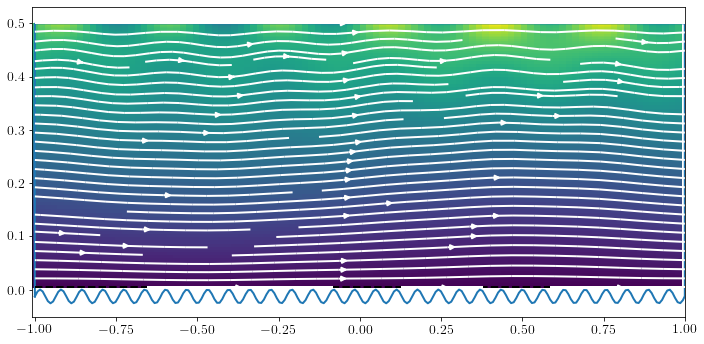

In [82]:


setup.hmm_problem.data.plot(plt.gca())
macro_sol.u.change_dim(101, 101).plot(plt.gca())
macro_sol.plot_stream(plt.gca(), 100, color='white')